# Master's thesis - Lukas Meuris - graphCast evaluation

This notebook contains the code to evaluate the models. 


In [ ]:
#!pip install git+https://github.com/google-research/weatherbench2.git

In [15]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs

import optax

import os
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

import weatherbench2
from weatherbench2 import config

import matplotlib.pyplot as plt

# Specify input datasets



In [4]:
# load obs data:
relative_path = "ERA5_data/1959-2022-6h-64x32_equiangular_conservative.zarr"
obs_path = os.path.join(os.path.dirname(os.getcwd()), relative_path)

In [ ]:
#load forecast data:
# """!change predictions path"""
# relative_path = "predictions/pred_64x32_2020_mae2.zarr"
# pred_path = os.path.join(os.path.dirname(os.getcwd()), relative_path)
# pred_data = xr.open_zarr(pred_path)
# pred_data = pred_data.rename({'lon': 'longitude','lat': 'latitude'})

In [5]:
"""!change predictions path"""
relative_path = "predictions/pred_64x32_2020_mae_eval.zarr"
pred_path = os.path.join(os.path.dirname(os.getcwd()), relative_path)
# pred_data.to_zarr(pred_path, mode='w')
# pred_data

In [6]:
# load climatology:
relative_path = "ERA5_data/climatology.zarr"
climatology_path = os.path.join(os.path.dirname(os.getcwd()), relative_path)
climatology = xr.open_zarr(climatology_path)

# Set up WeatherBench configuration

Next, we will define a bunch of configuration instances to specify exactly what we want to evaluate.

## data configuration
The file paths are defined in a Paths config object, alongside an output directory:

In [ ]:
paths = config.Paths(
    forecast=pred_path,
    obs=obs_path,
    output_dir='../evaluation/',   # Directory to save evaluation results
)

In addition, we specify a Selection object that selects the variables and time period to be evaluated.

In [ ]:
selection = config.Selection(
    variables=[
        'geopotential',
        'temperature',
        'u_component_of_wind',
        'v_component_of_wind',
        'specific_humidity',
        '2m_temperature',
        'mean_sea_level_pressure',
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-12-31'),
)

Together they make up the Data config:

In [ ]:
data_config = config.Data(selection=selection, paths=paths)

In [ ]:
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
# Default regions
predefined_regions = {
      'global': SliceRegion(),
      'tropics': SliceRegion(lat_slice=slice(-20, 20)),
      'extra-tropics': SliceRegion(
          lat_slice=[slice(None, -20), slice(20, None)]
      ),
      'northern-hemisphere': SliceRegion(lat_slice=slice(20, None)),
      'southern-hemisphere': SliceRegion(lat_slice=slice(None, -20)),
      # 'europe': SliceRegion(
      #     lat_slice=slice(35, 75),
      #     lon_slice=[slice(360 - 12.5, None), slice(0, 42.5)],
      # ),
      # 'north-america': SliceRegion(
      #     lat_slice=slice(25, 60), lon_slice=slice(360 - 120, 360 - 75)
      # ),
      # 'north-atlantic': SliceRegion(
      #     lat_slice=slice(25, 65), lon_slice=slice(360 - 70, 360 - 10)
      # ),
      # 'north-pacific': SliceRegion(
      #     lat_slice=slice(25, 60), lon_slice=slice(145, 360 - 130)
      # ),
      # 'east-asia': SliceRegion(
      #     lat_slice=slice(25, 60), lon_slice=slice(102.5, 150)
      # ),
      # 'ausnz': SliceRegion(
      #     lat_slice=slice(-45, -12.5), lon_slice=slice(120, 175)
      # ),
      # 'arctic': SliceRegion(lat_slice=slice(60, 90)),
      # 'antarctic': SliceRegion(lat_slice=slice(-90, -60)),
  }

global_region = {
    'global': SliceRegion()
} 

#### Evaluation configuration

Next, we can defined which evaluation we want to run. To do so, we can define a dictionary of `config.Eval`s, each of which will be evaluated separately and saved to a different file. Eval instances contain the metrics objects, defined in metrics.py.

Note that for ACC, we additionally need to pass the climatology opened earlier.

The evaluation configs also have an option to evaluate particular regions, such as a geographical lat-lon box. These are defined as region objects defined in regions.py. All regions will be evaluated separately and saved as an additional dimension in the dataset. If no region is specified, evaluation will be done globally.

In [ ]:
from weatherbench2.metrics import MSE, ACC, Bias, MAE, SpatialBias, SpatialMSE, SpatialMAE

det_metrics={
      'mse': MSE(),
      'acc': ACC(climatology=climatology),
      'bias': Bias(),
      'mae': MAE(), 
}
spatial_metrics = {
      'bias': SpatialBias(),
      'mse': SpatialMSE(),
      'mae': SpatialMAE(),
}

"""!change save path"""
eval_configs = {
  'mae_det': config.Eval(
      metrics=det_metrics,
      regions=global_region,
      evaluate_persistence=False),
  'mae_spatial': config.Eval(
    metrics=spatial_metrics,
    regions=global_region,
    evaluate_persistence=False,
    output_format='zarr')
}

### Evaluate

Now, we are already done and can run the evaluation. We can do so in memory for smaller datasets or as a Beam pipeline (recommended for anything larger than 64x32 resolution).

In [ ]:
from weatherbench2.evaluation import evaluate_in_memory

evaluate_in_memory(data_config, eval_configs)   # Takes some time.

# Deterministic results

In [7]:
results_gc = xr.open_dataset('../evaluation/gc_det.nc')
results_mse = xr.open_dataset('../evaluation/mse_det.nc')
results_mae = xr.open_dataset('../evaluation/mae_det.nc')

In [8]:
results_mse = xr.concat(
    [results_mse,
    results_mse.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5],
    dim='metric'
)
results_mae = xr.concat(
    [results_mae,
    results_mae.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5],
    dim='metric'
)

In [9]:
#convert time from ns to days.
results_gc['lead_time'] = results_gc['lead_time'].astype('timedelta64[ns]') / pd.Timedelta(days=1)
results_mse['lead_time'] = results_mse['lead_time'].astype('timedelta64[ns]') / pd.Timedelta(days=1)
results_mae['lead_time'] = results_mae['lead_time'].astype('timedelta64[ns]') / pd.Timedelta(days=1)

In [10]:
# remove initial time from results.
results_mse = results_mse.isel(lead_time=slice(1,41))
results_mae = results_mae.isel(lead_time=slice(1,41))

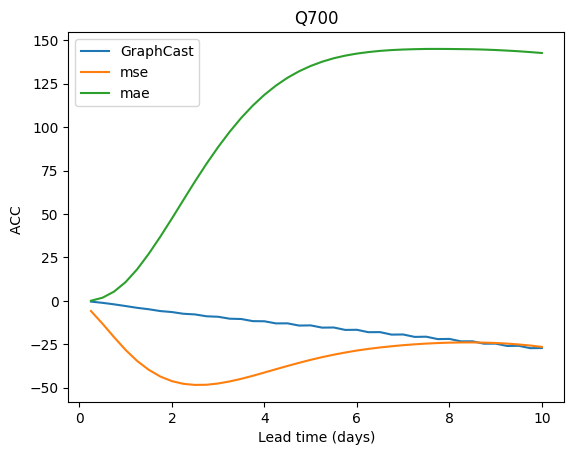

In [14]:
plt.figure()
#plot the datasets:
var = 'specific_humidity'
metric = 'acc'
level =700
region='global'
title = 'Q700'
units = "[Pa]"

results_gc[var].sel(metric=metric, level=level, region=region).plot(label='GraphCast')
results_mse[var].sel(metric=metric, level=level, region=region).plot(label='mse')
results_mae[var].sel(metric=metric, level=level, region=region).plot(label='mae')


# Add legend, title and labels
plt.legend()
plt.title(title)
plt.ylabel("ACC ")
plt.xlabel("Lead time (days)")

#save plot to file
#plt.savefig('../plots/ACC/' + title + '.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# spatial results
spatial results show the results by lon x lat on a world map

## Prediction
show one 10 day forecast for 2020-01-01

In [17]:
# show predictions for 2020-01-01:
relative_path = "predictions/pred_64x32_2020_mae_eval.zarr"
pred_path = os.path.join(os.path.dirname(os.getcwd()), relative_path)
pred_data = xr.open_zarr(pred_path)
pred_data = pred_data.isel(time=0).compute()

<Figure size 640x480 with 0 Axes>

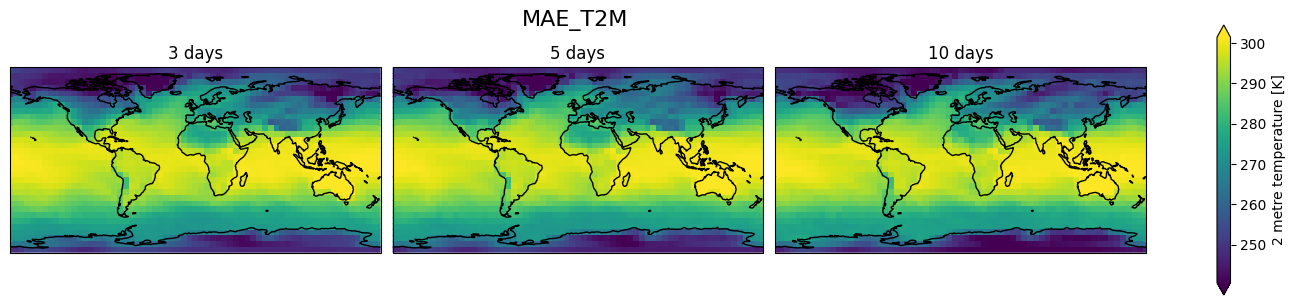

In [51]:
plt.figure()
g = pred_data['2m_temperature'].isel(prediction_timedelta=[12,20,40]).plot(x='longitude',
                                                                           y='latitude',
                                                                           col="prediction_timedelta",
                                                                           col_wrap=3,
                                                                           robust=True,
                                                                           subplot_kws={'projection': ccrs.PlateCarree()},
                                                                           aspect=1.5)
title = 'MAE_T2M'
# Manually set titles for each subplot
subtitles = ['3 days', '5 days', '10 days']
for ax, subtitle in zip(g.axs.flat, subtitles):
    ax.set_title(subtitle)
    ax.coastlines()

plt.suptitle(title, fontsize=16, x=0.4, y=1)
plt.savefig('../plots/Predictions/' + title + '.png', dpi=300, bbox_inches='tight')
plt.show()

## bias map
show the bias maps for 2020

In [ ]:
results_gc = xr.open_dataset('../evaluation/gc_spatial.nc')
results_mse = xr.open_dataset('../evaluation/mse_spatial.nc')
results_mae = xr.open_dataset('../evaluation/mae_spatial.nc')

<Figure size 640x480 with 0 Axes>

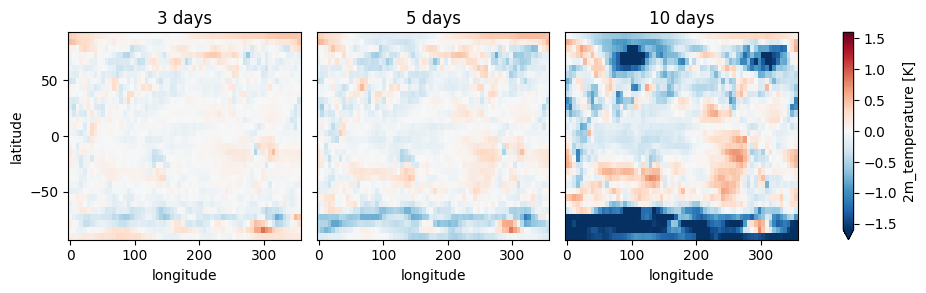

In [195]:
plt.figure()
var = 'specific_humidity'
title = 'Q700'
units = " [g/kg]"
level = 700
region = 'global'

lead_times = [np.timedelta64(3, 'D'),np.timedelta64(5, 'D'),np.timedelta64(10, 'D')]

g = results_mse[var].sel(metric='bias',level=level, region=region, lead_time=lead_times).plot(x='longitude',y='latitude',col="lead_time", robust=True, cbar_kwargs={"label": var + units})

# Manually set titles for each subplot
subtitles = ['3 days', '5 days', '10 days']
for ax, subtitle in zip(g.axs.flat, subtitles):
    ax.set_title(subtitle)

plt.savefig('../plots/Bias_maps/mse_' + title + '.png', dpi=300, bbox_inches='tight')
plt.show()

end of notebook.